In [1]:
import os
import json
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

# 处理数据


## DataSet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = np.load('/content/drive/MyDrive/咕泡/医学领域深度学习实战/基于ResNet医学数据集分类实战/medmnist/breastmnist.npz')
print(dataset.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
train_images = dataset['train_images']
print(train_images[0].shape)

(28, 28)


In [5]:
train_labels = dataset['train_labels']
print(train_labels[0])

[1]


## 制作DataLoader

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

In [7]:
class BreastMnistDataset(Dataset):
  def __init__(self, img, label, transform=None):
    self.img = img
    self.label = label
    self.transform = transform
  
  def __len__(self):
    return len(self.img)

  def __getitem__(self, idx):
    image = self.img[idx]
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = self.label[idx]
    if self.transform:
      image = self.transform(image)
    label = torch.from_numpy(np.array(label)).long().squeeze()
    return image, label


In [8]:
root = np.load('/content/drive/MyDrive/咕泡/医学领域深度学习实战/基于ResNet医学数据集分类实战/medmnist/retinamnist.npz')
train_dataset = BreastMnistDataset(root['train_images'], root['train_labels'])

In [9]:
root = np.load('/content/drive/MyDrive/咕泡/医学领域深度学习实战/基于ResNet医学数据集分类实战/medmnist/retinamnist.npz')
val_dataset = BreastMnistDataset(root['val_images'], root['val_labels'])

In [10]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [11]:
len(train_dataset)

1080

In [12]:
len(val_dataset)

120

### 用之前试试，整个数据和标签是否对应

In [13]:
!pip install --upgrade matplotlib
!pip install matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


torch.Size([3, 28, 28])
tensor(3)


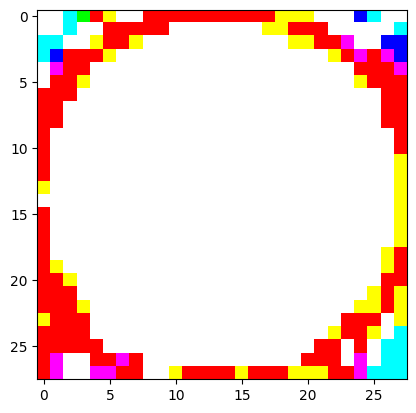

Label is: 3


In [15]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image[0].shape)
print(label[0])
sample = image[0].squeeze()
sample = sample.permute((1, 2, 0))
plt.imshow(sample)
plt.show()
print('Label is: {}'.format(label[0].numpy()))

## 把整理好的传入模型

In [17]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision

from torchvision import transforms, models, datasets

import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

In [18]:
dataloaders = {'train': train_loader, 'valid': val_loader}

In [19]:
model_name = 'resnet'
feature_extract = True

In [20]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU ...')
else:
  print('CUDA is available! Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available! Training on GPU ...


In [21]:
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 5))
input_size = 28
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()


# 训练模型


In [23]:
def train(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, filename='best.pth'):
  since = time.time()
  best_acc = 0
  model.to(device)

  val_acc_history = []
  train_acc_history = []
  train_losses = []
  valid_losses = []
  LRs = [optimizer.param_groups[0]['lr']]

  best_model_wts = copy.deepcopy(model.state_dict())

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # training and validation
    for phase in ['train', 'valid']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)
          #print('loss: ', loss)

          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      time_elapsed = time.time() - since
      print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'valid' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        state = {
          'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
          'best_acc': best_acc,
          'optimizer' : optimizer.state_dict(),#优化器的状态信息
        }
        torch.save(state, filename)
      if phase == 'valid':
          val_acc_history.append(epoch_acc)
          valid_losses.append(epoch_loss)
          scheduler.step(epoch_loss)#学习率衰减
      if phase == 'train':
          train_acc_history.append(epoch_acc)
          train_losses.append(epoch_loss)

    print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
    LRs.append(optimizer.param_groups[0]['lr'])
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # 训练完后用最好的一次当做模型最终的结果,等着一会测试
  model.load_state_dict(best_model_wts)
  return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs

In [24]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=17, filename='best.pth')

Epoch 0/16
----------
Time elapsed 0m 12s
train Loss: 1.5047 Acc: 0.4315
Time elapsed 0m 12s
valid Loss: 8.4310 Acc: 0.4500


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Optimizer learning rate : 0.0001000

Epoch 1/16
----------
Time elapsed 0m 13s
train Loss: 1.1871 Acc: 0.5269
Time elapsed 0m 13s
valid Loss: 1.1327 Acc: 0.5333
Optimizer learning rate : 0.0010000

Epoch 2/16
----------
Time elapsed 0m 18s
train Loss: 1.1554 Acc: 0.5157
Time elapsed 0m 18s
valid Loss: 1.0789 Acc: 0.5583
Optimizer learning rate : 0.0010000

Epoch 3/16
----------
Time elapsed 0m 19s
train Loss: 1.0897 Acc: 0.5528
Time elapsed 0m 19s
valid Loss: 1.1810 Acc: 0.4583
Optimizer learning rate : 0.0010000

Epoch 4/16
----------
Time elapsed 0m 19s
train Loss: 1.0905 Acc: 0.5315
Time elapsed 0m 19s
valid Loss: 1.0817 Acc: 0.5500
Optimizer learning rate : 0.0010000

Epoch 5/16
----------
Time elapsed 0m 19s
train Loss: 1.0331 Acc: 0.5676
Time elapsed 0m 19s
valid Loss: 1.1355 Acc: 0.4583
Optimizer learning rate : 0.0010000

Epoch 6/16
----------
Time elapsed 0m 20s
train Loss: 0.9973 Acc: 0.6019
Time elapsed 0m 20s
valid Loss: 1.2396 Acc: 0.4750
Optimizer learning rate : 0.001000